In [17]:
import triton
import torch
import os
import triton.language as tl
import cutlass
import cutlass.cute as cute
from cutlass.cute.runtime import from_dlpack


DEVICE = torch.device("cuda:0")

In [8]:
# Here we define the torch code

def torch_add(x, y):
    return x + y

In [5]:
# Here we define the torch compile code

@torch.compile
def torch_compile_add(x, y):
    return x + y

In [12]:
# Here we define the triton code

@triton.jit
def add_kernel(x_ptr,
               y_ptr,
               output_ptr,
               n_elements,
               BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask = mask)
    y = tl.load(y_ptr + offsets, mask = mask)
    z = x + y
    tl.store(output_ptr + offsets, z, mask = mask)

def triton_add(x, y):
    output = torch.empty_like(x)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n_elements = output.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    return output

In [ ]:
# Here we define the cute code

os.environ["PYTHONUNBUFFERED"] = 1

@cute.kernel
def vectorized_elementwise_add_kernel(
    gA: cute.Tensor,
    gB: cute.Tensor,
    gC: cute.Tensor,
):
    tidx, _, _ = cute.arch.thread_idx()
    bidx, _, _ = cute.arch.block_idx()
    bdim, _, _ = cute.arch.block_dim()

    thread_idx = bidx * bdim + tidx

    # Map thread index to logical index of input tensor
    m, n = gA.shape[1]       # thread-domain
    ni = thread_idx % n
    mi = thread_idx // n

    # Map logical index to physical address via tensor layout
    a_val = gA[(None, (mi, ni))].load()
    b_val = gB[(None, (mi, ni))].load()

    # Perform element-wise addition
    gC[(None, (mi, ni))] = a_val + b_val

@cute.jit
def vectorized_elementwise_add(
    mA: cute.Tensor,
    mB: cute.Tensor,
    mC: cute.Tensor
):
    threads_per_block = 256

    gA = cute.zipped_divide(mA, (4))
    gB = cute.zipped_divide(mB, (4))
    gC = cute.zipped_divide(mC, (4))

    vectorized_elementwise_add_kernel(gA, gB, gC).launch(
        grid=(cute.size(gC, mode=[1]) // threads_per_block, 1, 1),
        block=(threads_per_block, 1, 1),
    )

a = torch.randn(256, device="cuda", dtype=torch.float16)
b = torch.randn(256, device="cuda", dtype=torch.float16)
c = torch.zeros(256, device="cuda", dtype=torch.float16)
a_ = from_dlpack(a, assumed_align=16)
b_ = from_dlpack(b, assumed_align=16)
c_ = from_dlpack(c, assumed_align=16)
cute_dsl_add = cute.compile(vectorized_elementwise_add, a_, b_, c_)

def cute_dsl_add(x, y):
    out = torch.zeros_like(x)
    cute_x = from_dlpack(x, assumed_align=16)
    cute_y = from_dlpack(y, assumed_align=16)
    cute_out = from_dlpack(out, assumed_align=16)
    cute_dsl_add(cute_x, cute_y, cute_out)




In [ ]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 28, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'torch_compile', 'cute_dsl'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'Torch Compile', 'Cute dsl'],  # Label name for the lines.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='vector-add-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def benchmark(size, provider):
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    target_function = globals()[provider + "_add"]

    ms, min_ms, max_ms = triton.testing.do_bench(lambda: target_function(x, y), quantiles=quantiles)
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

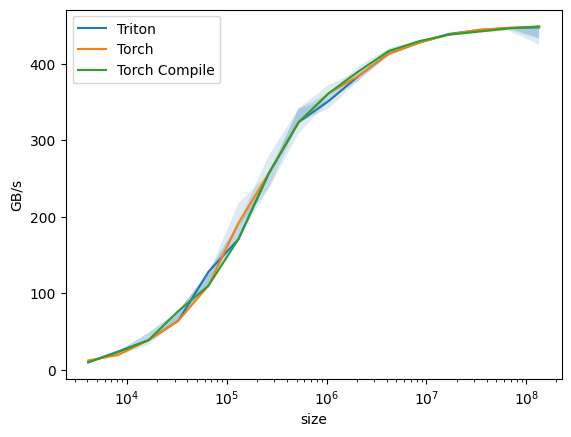

vector-add-performance:
           size      Triton       Torch  Torch Compile
0        4096.0    9.600000   12.000000       9.600000
1        8192.0   23.813955   19.200000      23.097745
2       16384.0   38.400001   38.400001      38.400001
3       32768.0   63.999998   63.999998      76.800002
4       65536.0  127.999995  109.714284     109.714284
5      131072.0  170.666661  192.000000     170.666661
6      262144.0  255.999991  255.999991     255.999991
7      524288.0  323.368435  323.368435     323.368435
8     1048576.0  351.085705  361.411758     361.245743
9     2097152.0  384.000001  384.000001     390.095241
10    4194304.0  413.042029  413.042029     416.542360
11    8388608.0  427.408686  427.408686     429.275114
12   16777216.0  438.857137  437.879719     437.879719
13   33554432.0  443.810387  444.311871     441.815718
14   67108864.0  446.582618  446.836360     446.075998
15  134217728.0  447.217514  448.237112     448.620660


In [15]:
benchmark.run(print_data=True, show_plots=True)